# Data Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

cleand_data_csv = 'data/cleaned_monthly.csv'
df = pd.read_csv(cleand_data_csv, index_col=0)
raw_df = df
df.shape

(1164, 28)

In [2]:
df.head()

,property_title,seller_id,seller_type,open_viewing,no_of_photos,available_from,available_for,area,furnished,bathrooms,...,Pets Allowed,Wheelchair Access,Central Heating,Microwave,Smoking,Dishwasher,House Alarm,Internet,property_description,pricerange
0,"1 BED, Tallaght Cross West, Tallaght, Dublin 24",9871.0,1.0,0.0,3.0,2017-10-01,12.0,66.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,*** UNFURNISHED*** Irish Residential Propert...,1
1,"1 Palace Street, Dublin 2, Dublin 2",7549.0,1.0,0.0,6.0,2017-09-15,12.0,65.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,***** HERBERT PROPERTY SERVICES****are delight...,2
2,"10 Clarinda House, Clarinda Park West, Dun Lao...",0.0,0.0,0.0,8.0,2017-09-18,6.0,9.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,Rating to be updated (new windows to be delive...,1
3,"10 Gandon Hall, Gardners Street, Dublin 1, Du...",0.0,0.0,0.0,5.0,2017-10-06,0.0,72.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,SHORT TERM OR LONG TERM LETTING-A renovated on...,1
4,"10 The Clayton, The Gasworks, Barrow Street, D...",0.0,0.0,0.0,7.0,2017-11-10,12.0,23.0,1.0,2.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,"CLAYTON, THE GASWORKS, BARROW STREET, DUBLIN 4...",2


In [3]:
print(df.columns.values)

['property_title' 'seller_id' 'seller_type' 'open_viewing' 'no_of_photos'
 'available_from' 'available_for' 'area' 'furnished' 'bathrooms' 'beds'
 'price' 'Parking' 'Cable Television' 'Dryer' 'Garden / Patio / Balcony'
 'Washing Machine' 'Serviced Property' 'Pets Allowed' 'Wheelchair Access'
 'Central Heating' 'Microwave' 'Smoking' 'Dishwasher' 'House Alarm'
 'Internet' 'property_description' 'pricerange']


## Price Range prediction based on description text

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.externals import joblib
nltk.download('punkt')


# Clean property_description text
def clean_text(desc_text):
    desc_text_clean = desc_text.str.replace("[-&().,!*//\\-?;+€'`:]"," ").str.lower()
    desc_text_clean = desc_text_clean.str.replace("\d"," ")
    desc_text_clean = desc_text_clean.str.replace("accomodation","accommodation")
    
    return desc_text_clean

desc_text_clean = clean_text(df['property_description'])

from collections import Counter   
wordlist = []
for row in desc_text_clean:
    wordlist += row.split()

#print(Counter(wordlist))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heididuchting/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Vectorize the text data
def get_vectorized_data(textdata):
    vectorizer = TfidfVectorizer(
        stop_words=None, tokenizer=nltk.word_tokenize, min_df=0.01, max_features=1000)
    desc_vect = vectorizer.fit_transform(textdata)
    vocab = vectorizer.get_feature_names() 
    
    return desc_vect

desc_vect = get_vectorized_data(desc_text_clean)
print(desc_vect.shape)

(1164, 1000)


The next step is building and saving the model for pricerange prediction by description text;
Uncomment when this model needs to be rebuild. Otherwise, load the existing model with 
`text_price_predictor = joblib.load('text_price_pred_pipeline.pkl')`

In [6]:
# # Build pipeline
# text_labels = df['pricerange']
# text_features = desc_vect
# np.isnan(text_labels).any()

# X_train, X_test, y_train, y_test = train_test_split(text_features, text_labels, test_size=0.2, random_state=42)

# # clf = MultinomialNB().fit(X_train, y_train)
# # accuracy/ narrowing word scope: 0.70815450643776823

# # Score on the training set was:0.74248927038626611
# pipeline = RandomForestClassifier(
#     bootstrap=True, criterion="entropy", n_estimators=100)

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print(acc)

# # Saving pipeline so we can use it in future
# joblib.dump(pipeline, 'text_price_pred_pipeline.pkl') 

## Price prediction, taking into account feature columns and price range prediction

In [7]:
from sklearn import preprocessing

desc_text_clean = clean_text(df['property_description'])
desc_vect = get_vectorized_data(desc_text_clean)

text_price_predictor = joblib.load('text_price_pred_pipeline.pkl') 
y_pred = text_price_predictor.predict(desc_vect)
df['range_pred'] = y_pred

features = ['seller_id','seller_type','no_of_photos','available_for','area','furnished','bathrooms',
            'beds','Cable Television','Dryer','Garden / Patio / Balcony','Washing Machine',
            'Serviced Property','Parking','Pets Allowed','Wheelchair Access','Central Heating',
            'Microwave','Smoking','Dishwasher','House Alarm','Internet','range_pred']

target = "price"


X_features = df[features]
Y = df[target]

X = preprocessing.StandardScaler().fit_transform(X_features)


In [8]:
print(X.shape)
print(Y.shape)

(1164, 23)
(1164,)


# Build Model with X & Y

## Trying Linear Regression

Accuracy: 0.69418934109


/Users/heididuchting/anaconda/envs/dlnd/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


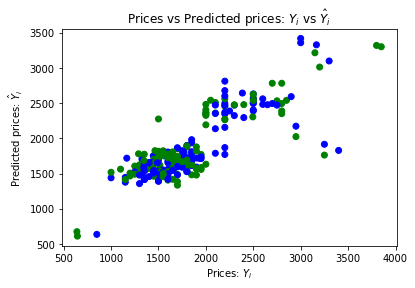

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

lm = LinearRegression()
lm.fit(X_train, Y_train)

Y_pred = lm.predict(X_test)
acc = r2_score(Y_test, Y_pred)
print("Accuracy: " + str(acc))

plt.scatter(Y_test, Y_pred, color=['green','blue'])
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

## Looking for a good model using TPOT

In [ ]:
from tpot import TPOTRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2)
tpot.fit(X_train, Y_train)
print(tpot.score(X_test, Y_test))
tpot.export('daft_rental_tpot.py')

# Trying Models suggested by TPOT

## StackingEstimator

In [10]:
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

training_features, testing_features, training_target, testing_target = \
    train_test_split(X, Y, random_state=42)

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingRegressor(
        alpha=0.99, 
        learning_rate=0.1, 
        loss="huber",
        max_depth=4, 
        max_features=0.7, 
        min_samples_leaf=14, 
        min_samples_split=16, 
        n_estimators=100, 
        subsample=0.9000000000000001)),
    LassoLarsCV(normalize=False)
)

exported_pipeline.fit(training_features, training_target)
Y_pred = exported_pipeline.predict(testing_features)
acc = r2_score(testing_target, Y_pred)
print("Accuracy: " + str(acc))


# plt.scatter(testing_target, Y_pred, color=['green','blue'])
# plt.xlabel("Prices: $Y_i$")
# plt.ylabel("Predicted prices: $\hat{Y}_i$")
# plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")


Accuracy: 0.453129062867


## XGBRegressor

Accuracy: 0.782509417142


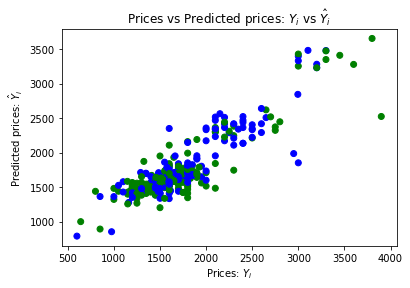

In [13]:
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

training_features, testing_features, training_target, testing_target = \
    train_test_split(X, Y, random_state=88)
    

#exported_pipeline = XGBRegressor(max_depth=4, min_child_weight=7, nthread=1, subsample=0.7500000000000001)
exported_pipeline = XGBRegressor(
    learning_rate=0.06, max_depth=5, min_child_weight=6, 
    n_estimators=120, nthread=1, subsample=0.7500000000000001)

exported_pipeline.fit(training_features, training_target)
pred_Y = exported_pipeline.predict(testing_features)
acc = r2_score(testing_target, pred_Y)
print("Accuracy: " + str(acc))

plt.scatter(testing_target, pred_Y, color=['green','blue'])
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

## GradientBoostingRegressor

Accuracy: 0.76918766974


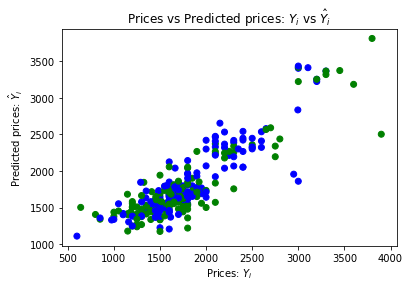

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

training_features, testing_features, training_target, testing_target = \
    train_test_split(X, Y, random_state=88)

# Score on the training set was:-127197.06953026657
exported_pipeline = make_pipeline(
    StandardScaler(),
    MaxAbsScaler(),
    StandardScaler(),
    GradientBoostingRegressor(
        alpha=0.95, learning_rate=0.1, loss="huber",
        max_depth=5, max_features=0.9500000000000001, min_samples_leaf=19, 
        min_samples_split=2, n_estimators=100, subsample=1.0)
)


exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
acc = r2_score(testing_target, results)
print("Accuracy: " + str(acc))

plt.scatter(testing_target, results, color=['green','blue'])
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

## Notes
- Accuracy increased after 'text to pricerange' classification was added.
- 'text to pricerange' classification accuracy can probably be increased by using an **LSTM** network instead of basic bag of words
- need more data for training. 